In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib as mpl
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd

In [2]:
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['legend.fontsize'] = 5
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Helvetica']

In [3]:
adata = sc.read('./../../data/processed/adata_reannotated_final.h5ad')

In [4]:
import pickle
with open('./../../results/DE/de_stress_new/pickle/new_function.pickle', 'rb') as f:
    de_post_df = pickle.load(f)
    
de_genes = pd.read_pickle('./../../results/DE/de_stress_new/pickle/genes.pickle')
de_genes_sign = de_genes[de_genes['qval']<0.05]
de_genes_sign_mean = de_genes_sign[(de_genes_sign['mean_pert']>0.1) | (de_genes_sign['mean_ctrl']>0.1)]
de_genes_sign_mean = de_genes_sign_mean[np.abs(de_genes_sign_mean['log2fc'])>0.1]

In [5]:
genes = de_genes_sign_mean[(de_genes_sign_mean['clust']=='CA1 Glut 1') & (de_genes_sign_mean['test']=='WT')]

In [6]:
pd.Series(genes['gene'].values).to_csv("genes.csv")

In [7]:
plt.rcParams['figure.dpi'] = 100
gene_adatas = {}
for clust in ['CA3 Glut 2']:
    print(clust)
    df_clust = de_genes[de_genes['clust'] == clust]
    df_clust['max_mean'] = np.max([df_clust['mean_ctrl'], df_clust['mean_pert']], axis=0)
    #df_clust = df_clust[(df_clust.mean_pert>0.1) | (df_clust.mean_ctrl>0.1)]
    #df_clust = df_clust[np.abs(df_clust.log2fc)>0.1]
    df_clust = df_clust[df_clust['test'].isin(['WT', 'GR_Nex', 'GR_Dlx', 'MR_Nex', 'MR_Dlx'])]
    d = df_clust[['log2fc', 'test', 'gene']].pivot(index='gene', columns='test', values='log2fc')
    d_pval = df_clust[['qval', 'test', 'gene']].pivot(index='gene', columns='test', values='qval')
    d_log = df_clust[['log2fc', 'test', 'gene']].pivot(index='gene', columns='test', values='log2fc')
    #d_mean = df_clust[['max_mean', 'test', 'gene']].pivot(index='gene', columns='test', values='max_mean')
    d = d.loc[(np.sum(d_pval < 0.05, axis=1) > 0)]# & (np.any(np.abs(d_log) > 0.1, axis=1)) & (np.any(d_mean > 0.5))]
    d = d.dropna()
    d_pval = d_pval.loc[d.index]
    gene_adatas[clust] = sc.AnnData(X=d.values, var=list(d.columns), obs=list(d.index))
    gene_adatas[clust].layers['pval'] = d_pval.values
    for i in range(gene_adatas[clust].shape[1]):
        gene_adatas[clust].obs[d.columns[i]] = gene_adatas[clust].X[:, i]
    df_clust = df_clust.set_index('gene')

    gene_adatas[clust].obs_names = gene_adatas[clust].obs[0]
    sc.pp.neighbors(gene_adatas[clust])
    sc.tl.umap(gene_adatas[clust])
    sc.tl.tsne(gene_adatas[clust])
    sc.tl.leiden(gene_adatas[clust], resolution=1)


CA3 Glut 2


<ipython-input-7-281d8218fc36>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clust['max_mean'] = np.max([df_clust['mean_ctrl'], df_clust['mean_pert']], axis=0)


In [8]:
gene_adatas[clust].obs.loc['Resp18']

0           Resp18
GR_Dlx    0.389357
GR_Nex   -0.369525
MR_Dlx   -0.396676
MR_Nex    0.578682
WT        0.120066
leiden           8
Name: Resp18, dtype: object

In [9]:
gene_adatas[clust].obs.groupby('leiden').size()

leiden
0     456
1     376
2     362
3     358
4     340
5     313
6     304
7     300
8     299
9     246
10    222
11    200
12    187
13    180
14     52
dtype: int64

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future versi

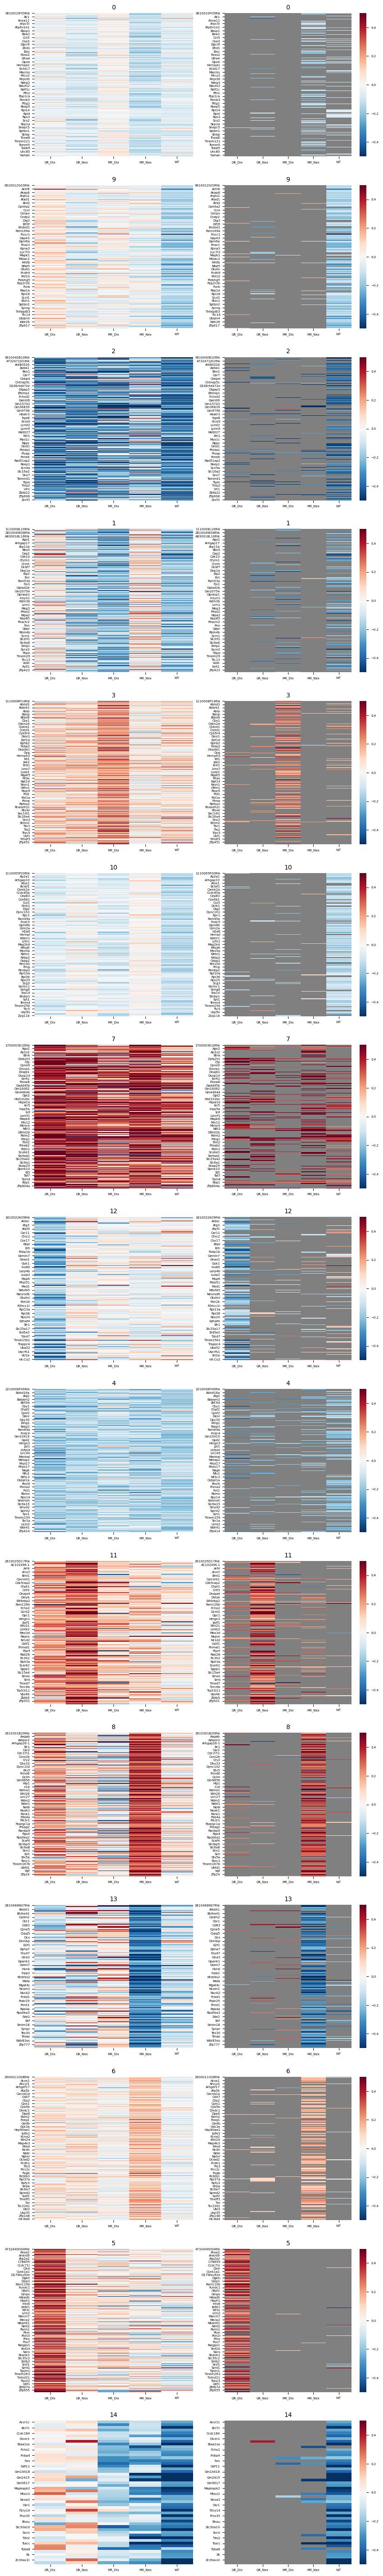

In [10]:
fig, ax = plt.subplots(
   len(gene_adatas[clust].obs.leiden.cat.categories), 
   2, 
   figsize=(10, len(gene_adatas[clust].obs.leiden.cat.categories)*5)
)
clust = 'CA3 Glut 2'
for i, cat in enumerate(gene_adatas[clust].obs.leiden.unique()):
    g = gene_adatas[clust][gene_adatas[clust].obs.leiden==cat]
    cm_pval = col.ListedColormap(['grey'])
    g_pval = pd.DataFrame(g.layers['pval'].copy())
    sns.heatmap(g.X, cmap='RdBu_r', center=0, vmin=-0.5, vmax=0.5, ax=ax[i, 0], cbar=False)
    sns.heatmap(g.X, cmap='RdBu_r', center=0, vmin=-0.5, vmax=0.5, ax=ax[i, 1], cbar=True)
    sns.heatmap(g_pval[g_pval>0.05], cmap=cm_pval, center=0, vmin=-0.5, vmax=0.5, ax=ax[i, 1], cbar=False)
    ax[i, 0].set_yticklabels(ax[i, 0].get_yticklabels(), rotation=0)
    ax[i, 0].set_yticklabels(g.obs[0].iloc[ax[i, 0].get_yticks()])
    ax[i, 0].set_xticklabels(g.var[0])
    ax[i, 0].set_title(cat)
    ax[i, 1].set_yticklabels(ax[i, 1].get_yticklabels(), rotation=0)
    ax[i, 1].set_yticklabels(g.obs[0].iloc[ax[i, 1].get_yticks()])
    ax[i, 1].set_xticklabels(g.var[0])
    ax[i, 1].set_title(cat)

In [35]:
def plot_heatmap(de_genes, clust, genes, mask=True, savefig=None):
    plt.ioff()
    de_genes_plot = de_genes[
    (de_genes['gene'].isin(genes))
    & (de_genes['clust']==clust)
    ]
    de_genes_plot = de_genes_plot[
        ~de_genes_plot['test'].isin(['WT_GR','WT_MR'])
    ]
    de_genes_plot['test'] = de_genes_plot['test'].astype('category')
    print(de_genes_plot.test.cat.categories)
    de_genes_plot['test'] = de_genes_plot['test'].cat.reorder_categories([
        'WT',
        'GR_Nex',
        'GR_Dlx',
        'MR_Nex',
        'MR_Dlx'
    ])
    pivot_mean_pert = de_genes_plot.pivot(columns='test', index='gene', values='mean_pert')
    pivot_mean_ctrl = de_genes_plot.pivot(columns='test', index='gene', values='mean_ctrl')
    pivot_qval = de_genes_plot.pivot(columns='test', index='gene', values='qval')
    pivot_log2fc = de_genes_plot.pivot(columns='test', index='gene', values='log2fc')
    qval_mask = (
        (pivot_qval < 0.05) 
        #& ((pivot_mean_pert > 0.1) | (pivot_mean_ctrl > 0.1)) 
        #& (np.abs(pivot_log2fc) > 0.1)
    )
    pivot_log2fc.fillna(value=0, inplace=True)
    idx_sign = np.any(qval_mask==True, axis=1)
    qval_mask = qval_mask[idx_sign]
    pivot_log2fc = pivot_log2fc[idx_sign]
    
    qval_idx = pd.DataFrame(index=qval_mask.index)
    qval_idx_2 = pd.DataFrame(index=qval_mask.index)
    for i, col in enumerate(qval_mask.columns):
        qval_idx[col] = pd.Series(index=qval_mask.index, data=(10)*np.ones(len(qval_mask)))
        qval_idx_2[col] = pd.Series(index=qval_mask.index, data=(i**2)*np.ones(len(qval_mask)))
    qval_tot = pd.DataFrame(index=qval_mask.index)
    qval_tot['idx_cond'] = qval_idx[qval_mask].fillna(0).sum(1)
    qval_tot['idx_within_cond'] = qval_idx_2[qval_mask].fillna(0).sum(1)
    qval_tot['log2fc'] = pivot_log2fc[qval_mask].fillna(0).abs().sum(1)
    qval_tot = qval_tot.sort_values(['idx_cond', 'idx_within_cond', 'log2fc'], ascending=False)
    indices_reord = qval_tot.index
    if 'Resp18' in indices_reord:
        indices_reord = indices_reord[indices_reord!='Resp18']
        indices_reord = np.hstack([['Resp18'], indices_reord])
    
    pivot_log2fc = pivot_log2fc.reindex(indices_reord)
    pivot_qval = pivot_qval.reindex(indices_reord)
    pivot_mean_pert = pivot_mean_pert.reindex(indices_reord)
    pivot_mean_ctrl = pivot_mean_ctrl.reindex(indices_reord)
    
    qval_mask = (
        (pivot_qval < 0.05) 
        & ((pivot_mean_pert > 0.1) | (pivot_mean_ctrl > 0.1)) 
        & (np.abs(pivot_log2fc) > 0.1)
    )
    fig, ax = plt.subplots(1, 1, figsize=(0.15*len(pivot_log2fc), 2))
    sns.heatmap(
        pivot_log2fc.T,
        annot=False,
        cmap='RdBu_r',
        center=0,
        ax=ax,
        mask=~qval_mask.T if mask==True else None,
        square=True,
        linewidth=.5,
        cbar=False,
        vmin=-0.5,
        vmax=0.5,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    if savefig is not None:
        fig.savefig(f'heatmaps/data_driven_{savefig}.png', dpi=500, bbox_inches='tight')
    plt.show()

Index(['GR_Dlx', 'GR_Nex', 'MR_Dlx', 'MR_Nex', 'WT'], dtype='object')


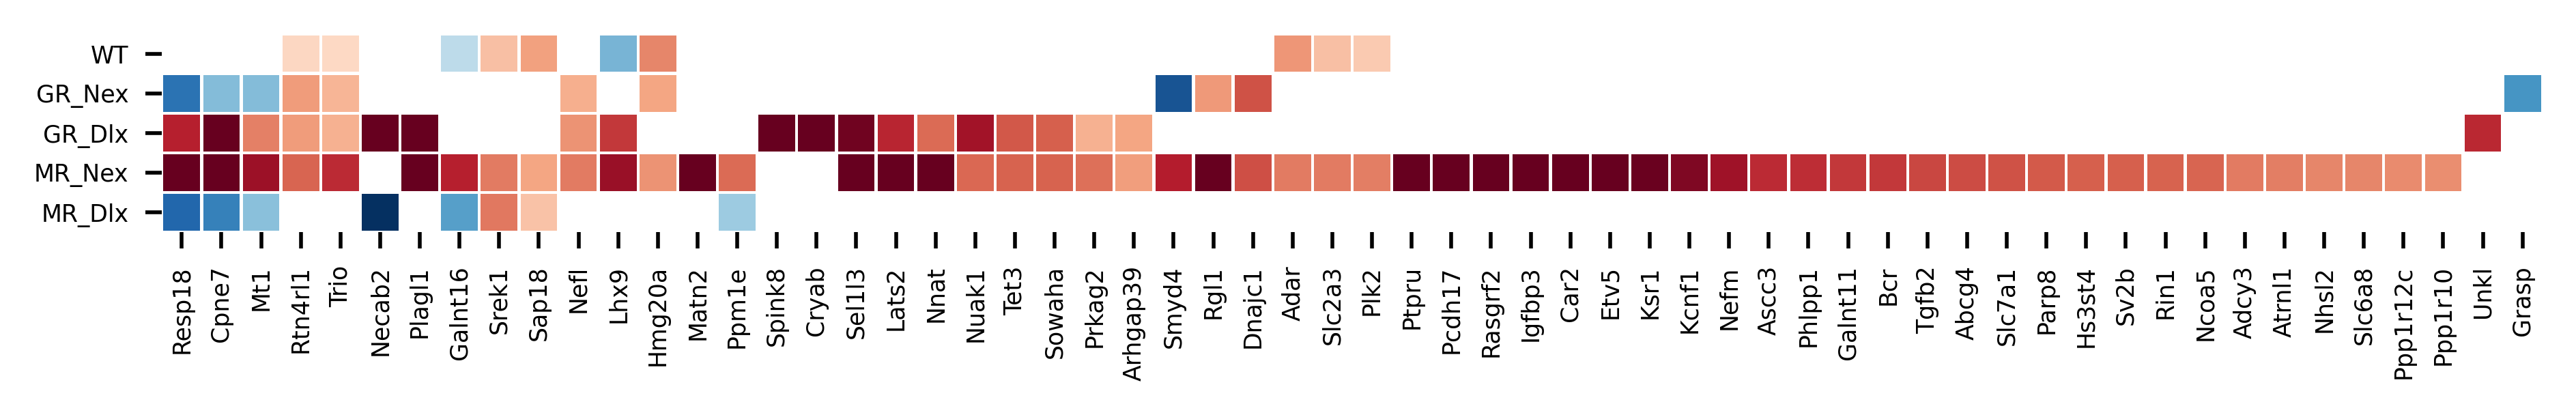

59


In [36]:
plt.rcParams['figure.dpi'] = 500
np.random.seed(0)
clust = 'CA3 Glut 2'
genes = gene_adatas[clust][gene_adatas[clust].obs.leiden=='8'].obs_names
genes = genes[genes.isin(genes_sign)]
genes = np.random.choice(genes, 59, replace=False)
genes = genes[genes!='Resp18']
plot_heatmap(
    de_genes_sign, 
    clust, 
    np.hstack([genes, ['Resp18']]),
    True,
    'ca3glut2_8'
)
print(len(genes))

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Index(['GR_Dlx', 'GR_Nex', 'MR_Dlx', 'MR_Nex', 'WT'], dtype='object')


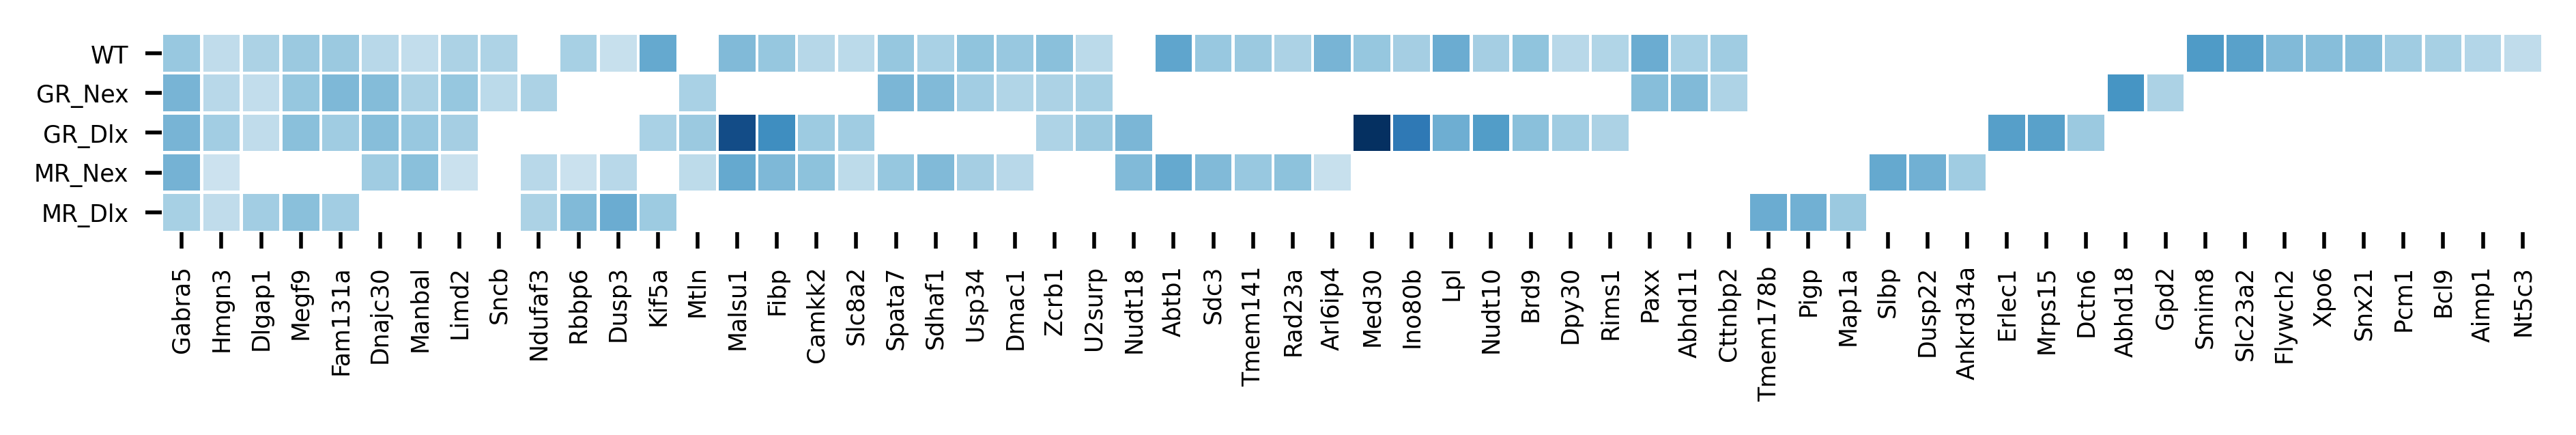

60


In [37]:
plt.rcParams['figure.dpi'] = 500
np.random.seed(0)
clust = 'CA3 Glut 2'
genes = gene_adatas[clust][gene_adatas[clust].obs.leiden=='4'].obs_names
genes = genes[genes.isin(genes_sign)]
genes = np.random.choice(genes, 60, replace=False)
plot_heatmap(
    de_genes_sign, 
    clust, 
    np.hstack([genes]),
    True,
    'ca3glut2_4'
)
print(len(genes))

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Index(['GR_Dlx', 'GR_Nex', 'MR_Dlx', 'MR_Nex', 'WT'], dtype='object')


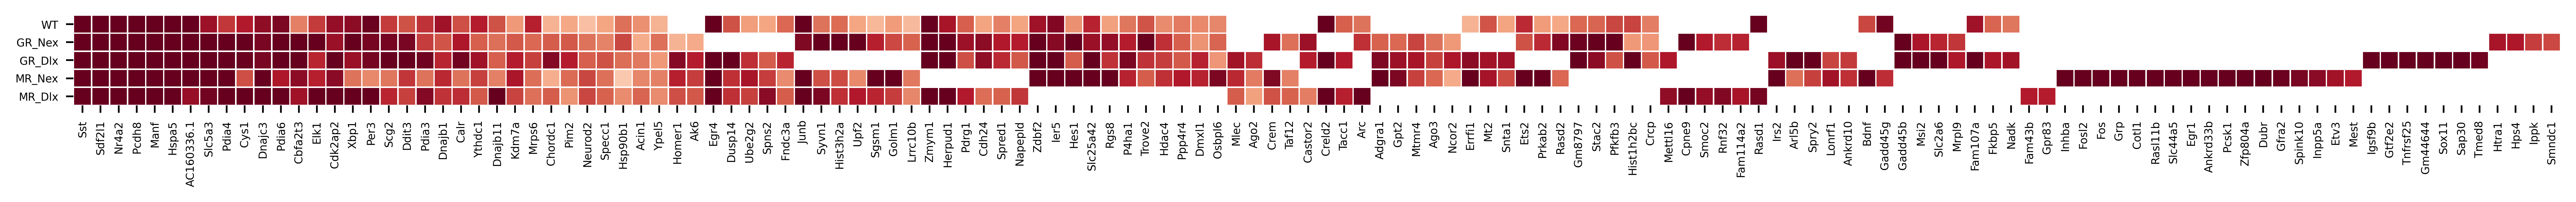

In [23]:
plt.rcParams['figure.dpi'] = 500
np.random.seed(0)
plot_heatmap(
    de_genes_sign_mean, 
    'CA3 Glut 2', 
    gene_adatas[clust][gene_adatas[clust].obs.leiden=='7'].obs_names,
    True
)

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


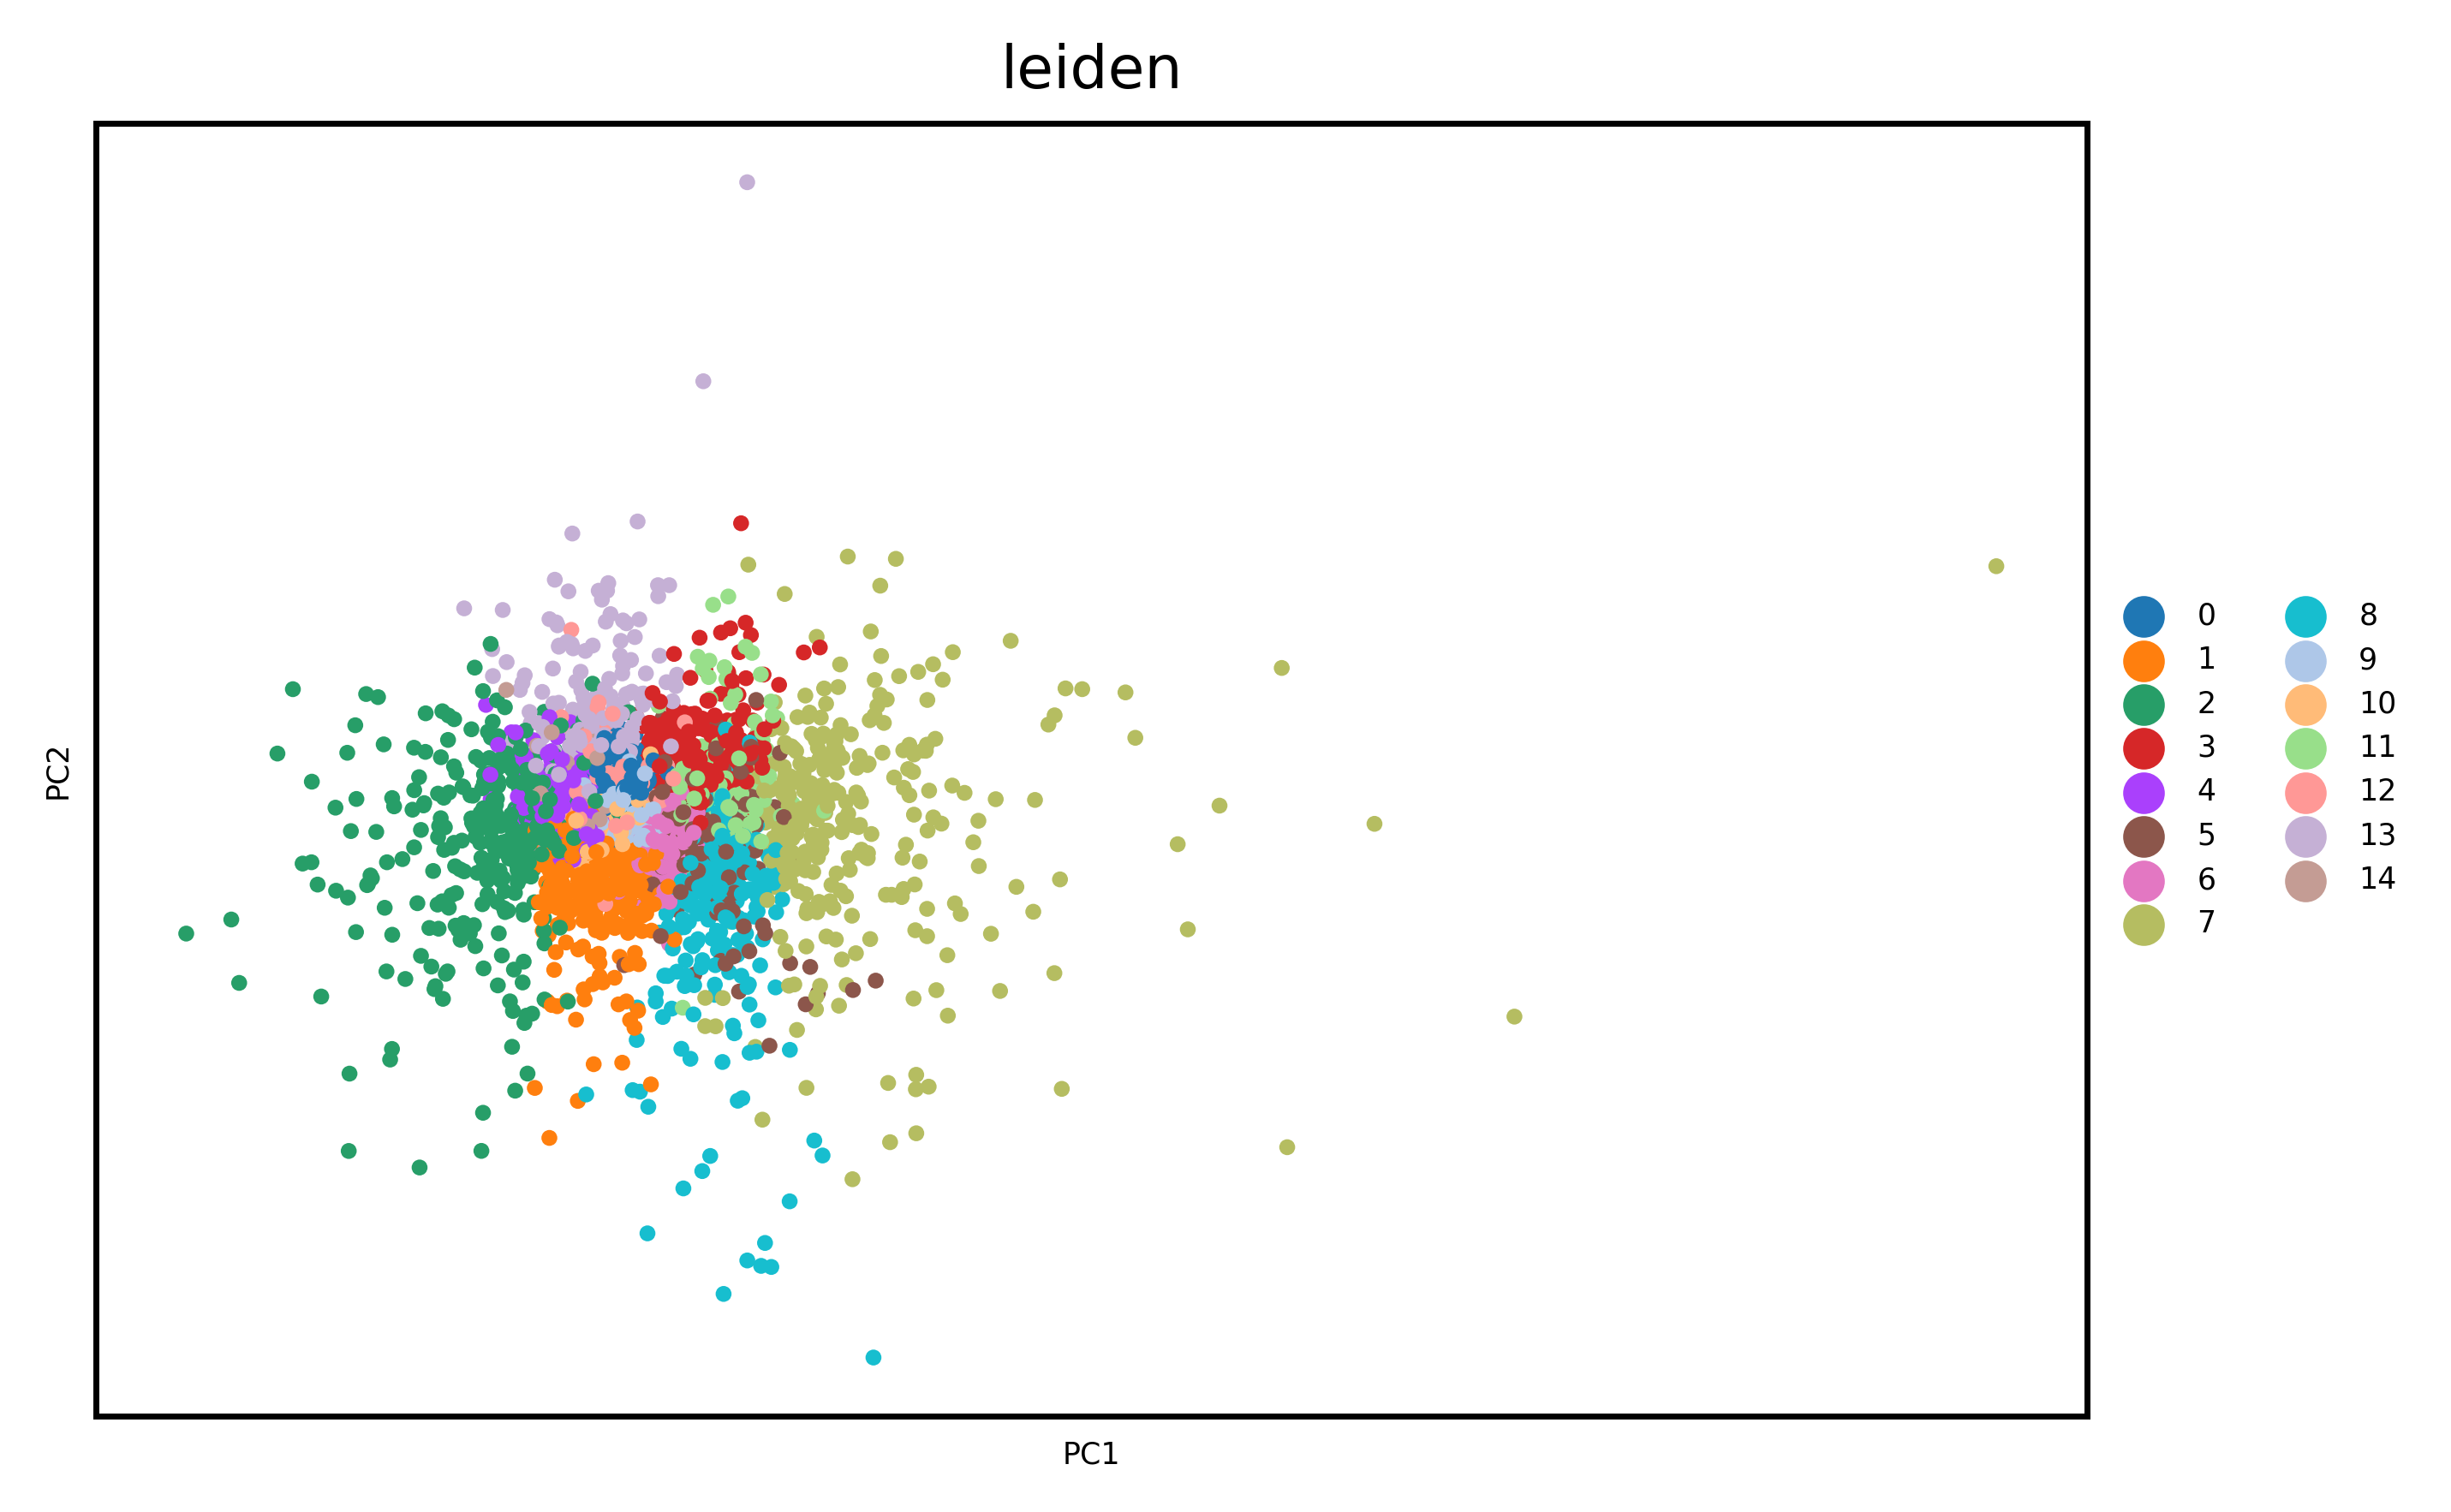

In [16]:
sc.pp.pca(gene_adatas[clust])
sc.pl.pca(gene_adatas[clust], color='leiden')

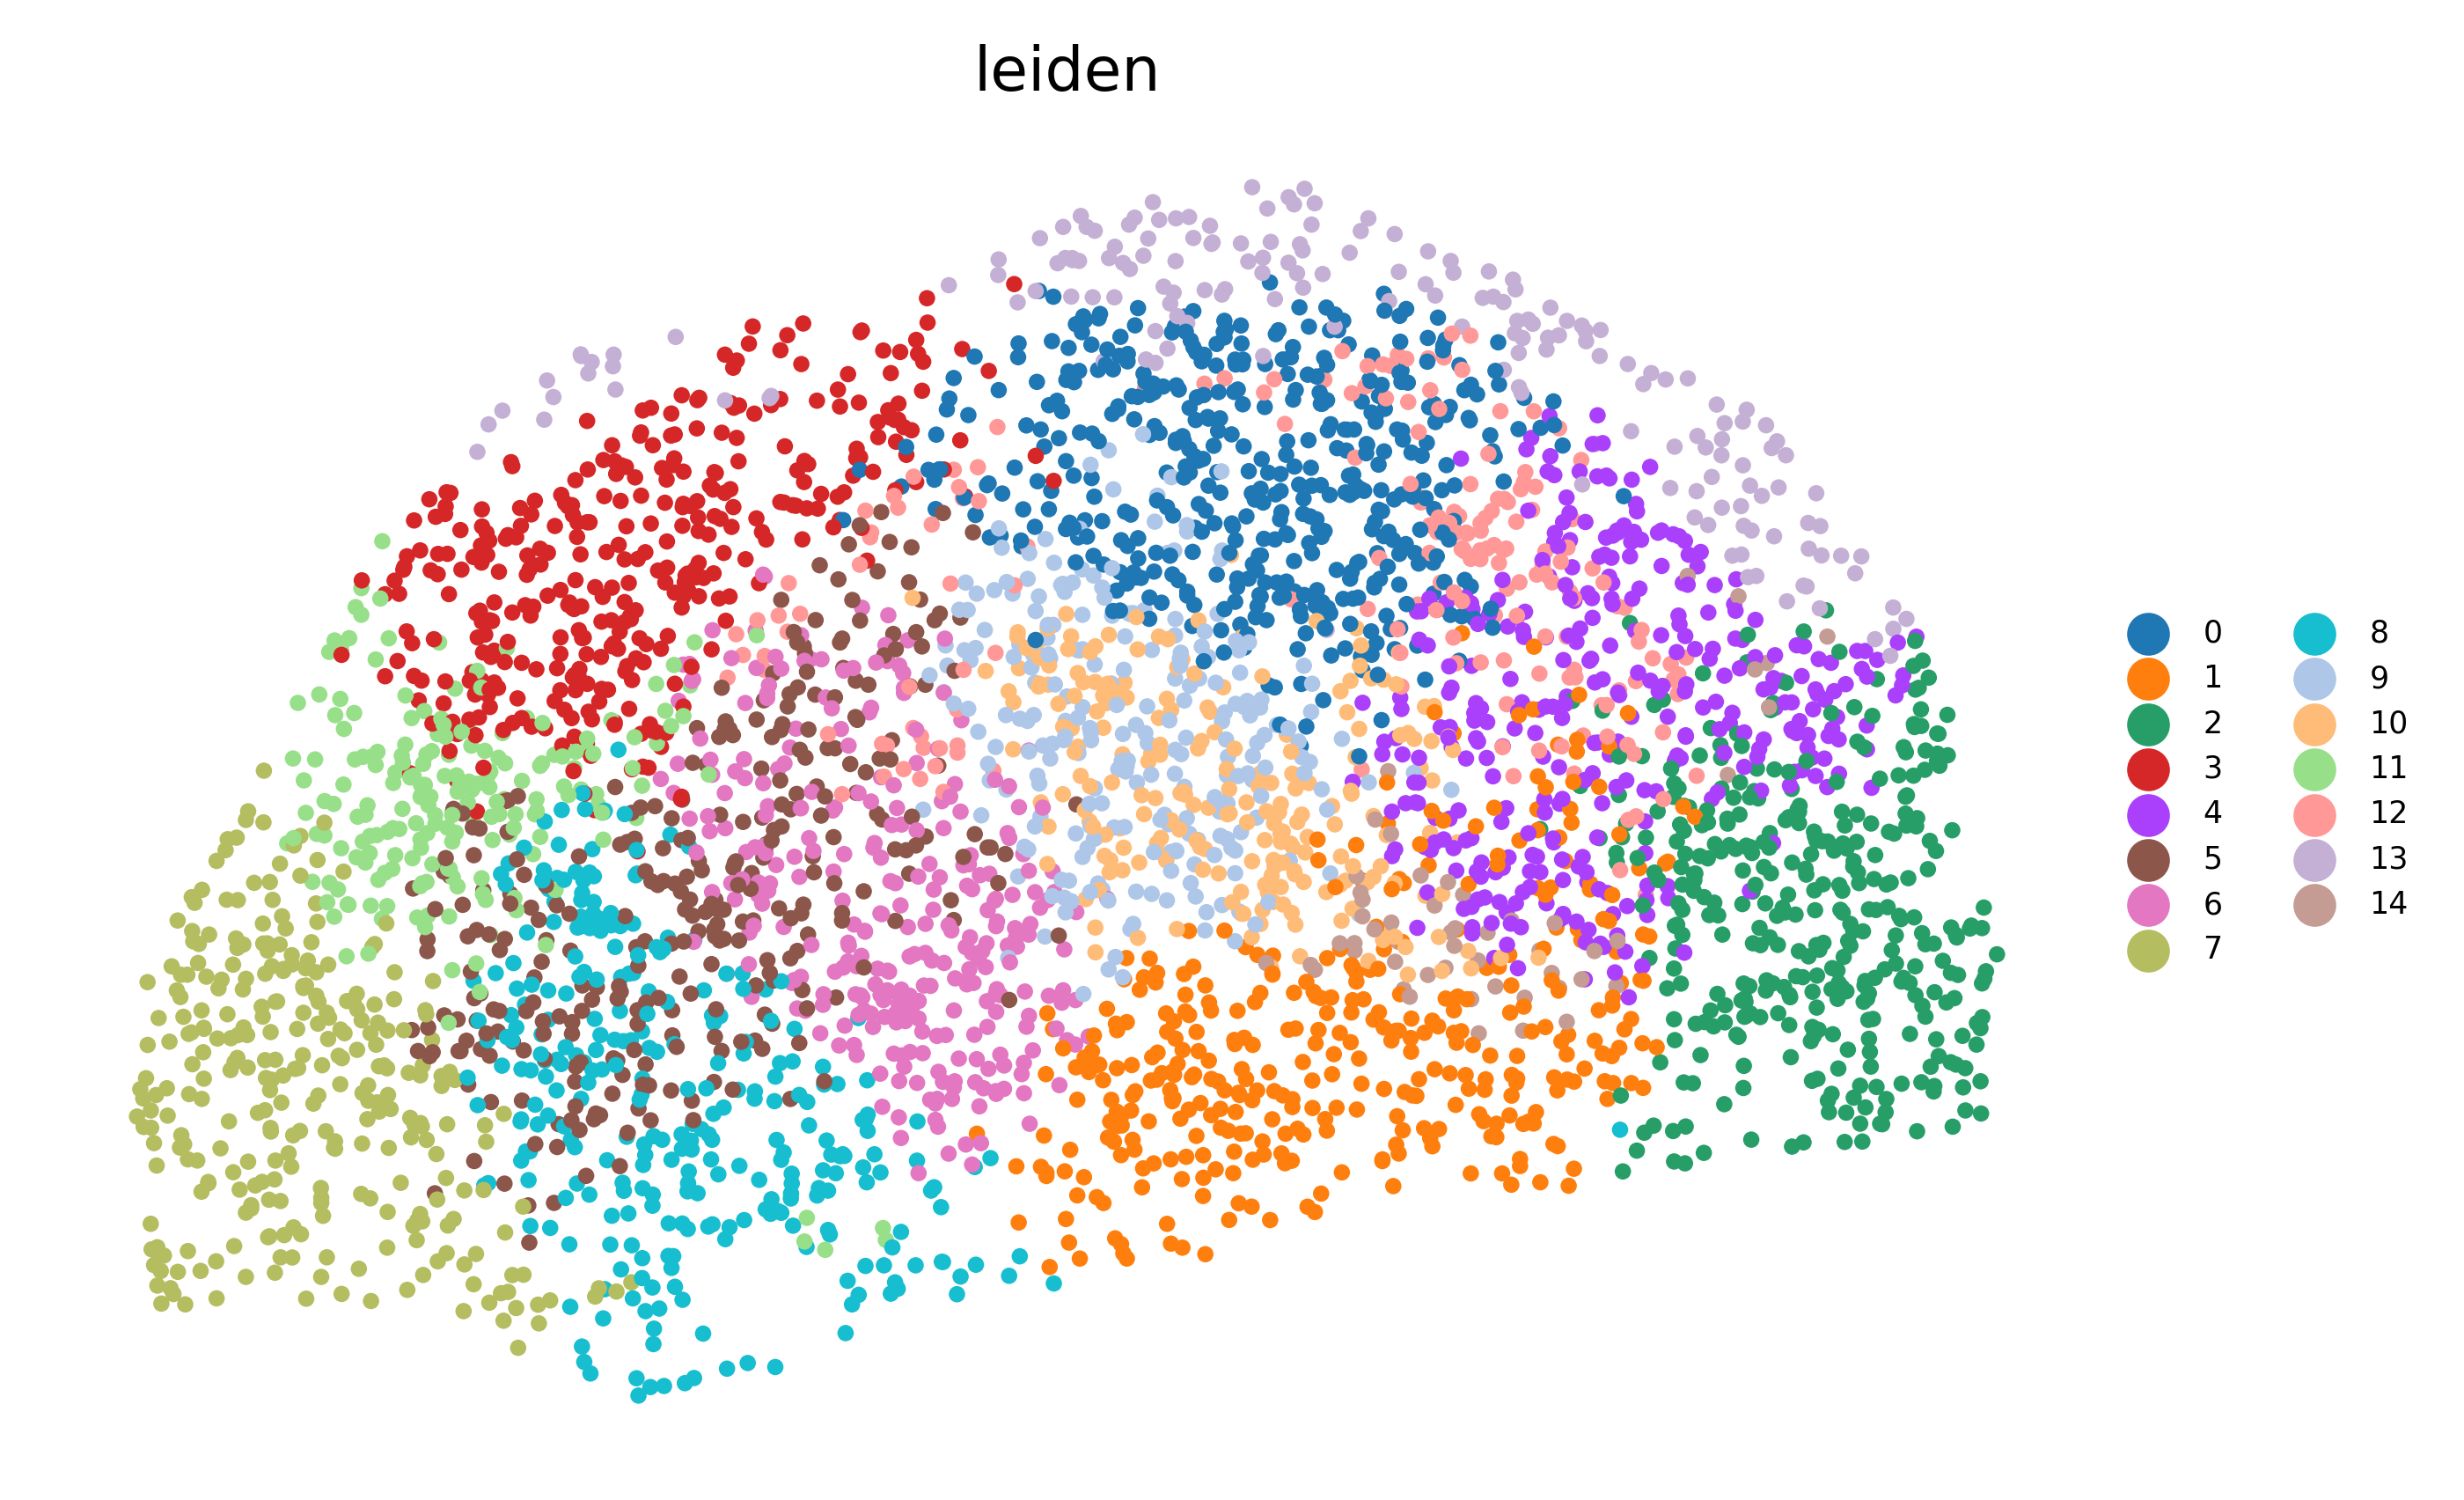

In [17]:
sc.pl.umap(gene_adatas[clust], color='leiden', frameon=False)

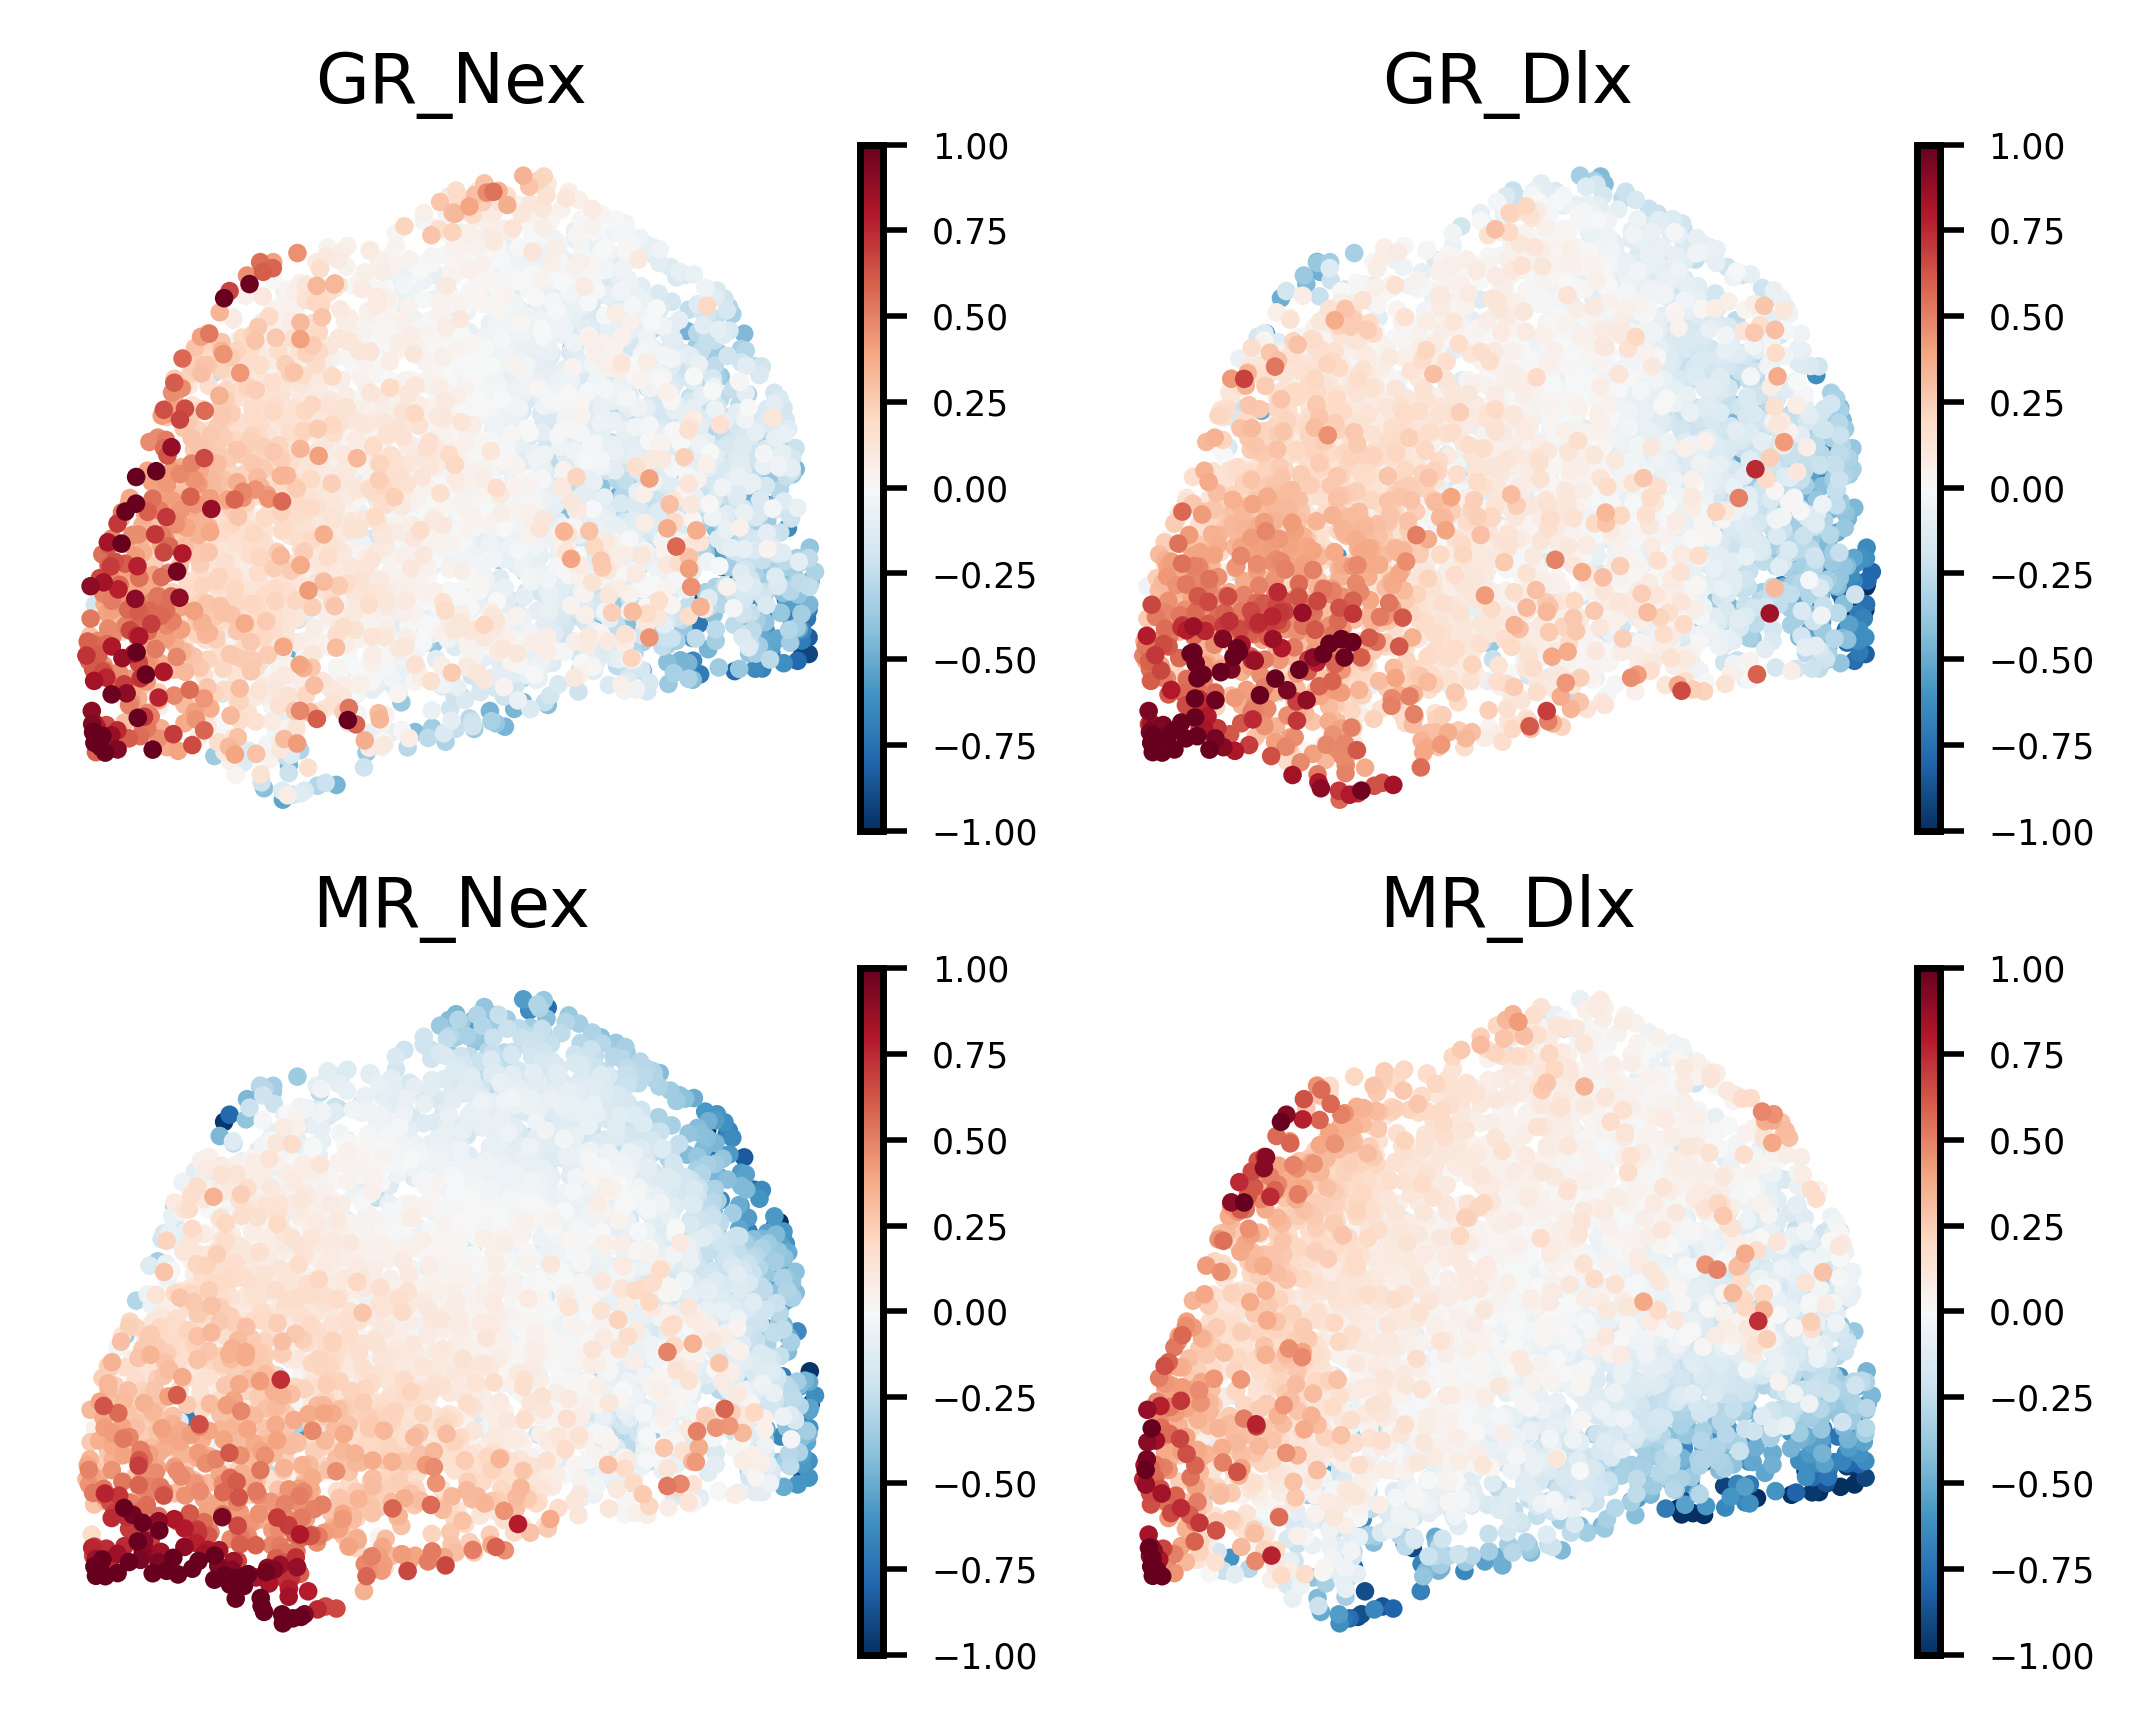

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(5, 4))
ax=ax.flatten()
for i, var in enumerate(['GR_Nex', 'GR_Dlx', 'MR_Nex', 'MR_Dlx']):
    p = sc.pl.umap(gene_adatas[clust], color=var, vmin=-1, vmax=1, show=False, frameon=False, ax=ax[i], cmap='RdBu_r')

In [ ]:
!pip install --upgrade upsetplot

CA1 Glut 2
CA3 Glut 2


<ipython-input-49-b680e2f8a78c>:29: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_list.append(upset_data_sub.loc[idx])
<ipython-input-49-b680e2f8a78c>:29: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_list.append(upset_data_sub.loc[idx])


DG Glut 2
Oligodendrocytes
Astro 1


<ipython-input-49-b680e2f8a78c>:29: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_list.append(upset_data_sub.loc[idx])
<ipython-input-49-b680e2f8a78c>:29: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_list.append(upset_data_sub.loc[idx])
<ipython-input-49-b680e2f8a78c>:29: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_list.append(upset_data_sub.loc[idx])
<ipython-input-49-b680e2f8a78c>:29: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_list.append(upset_data_sub.loc[idx])
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Endothelial


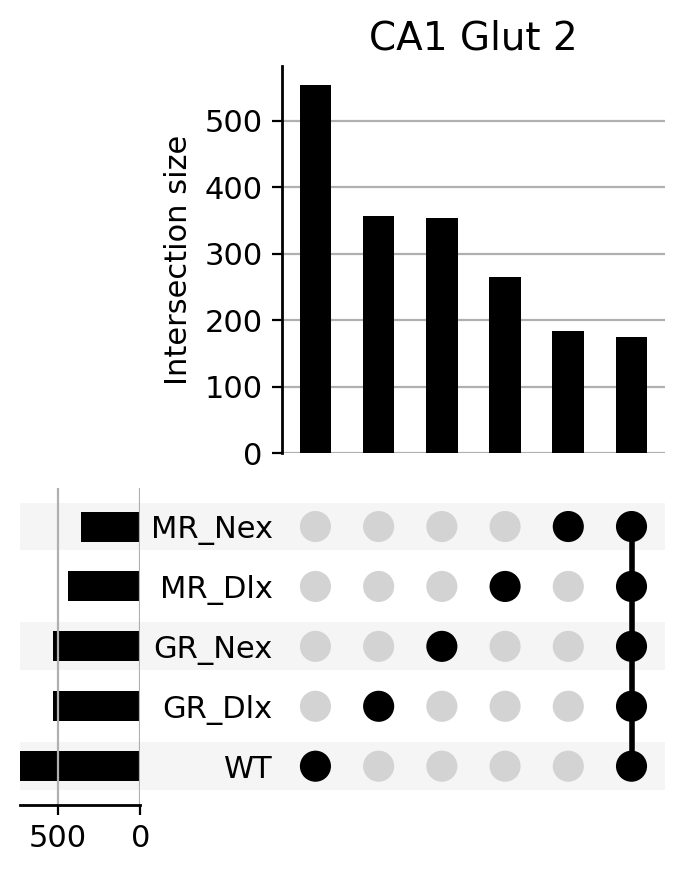

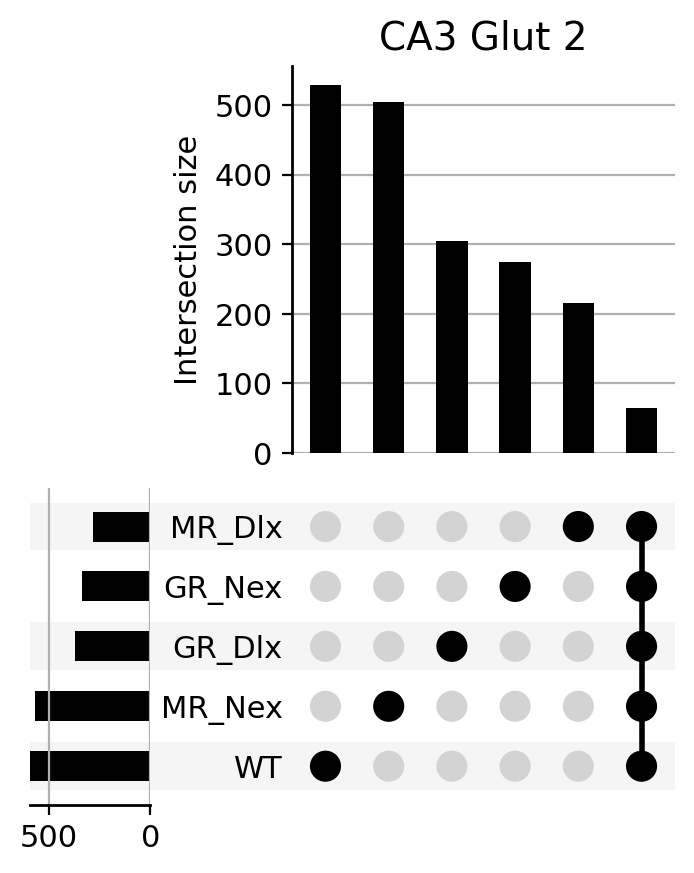

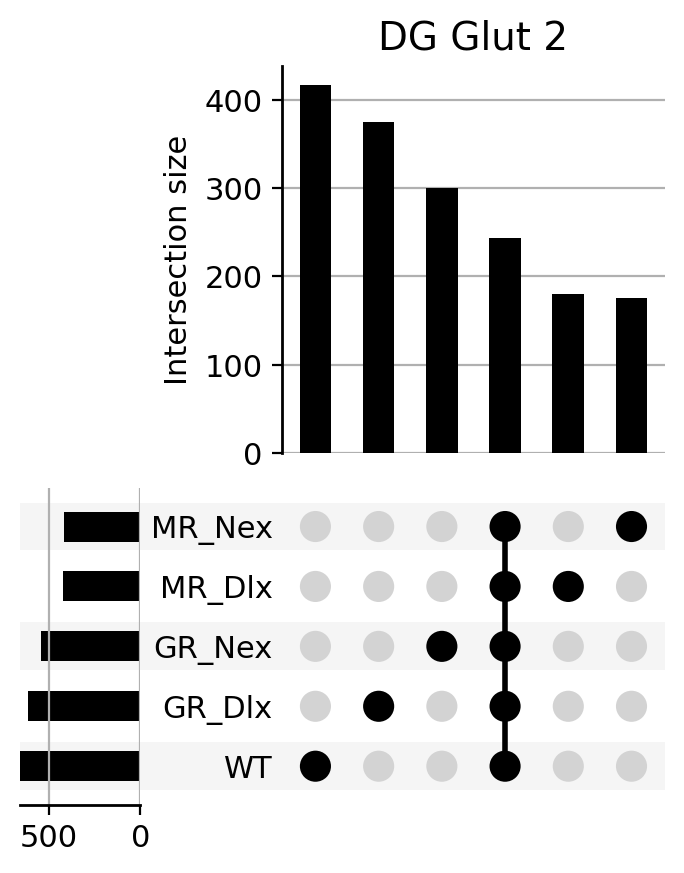

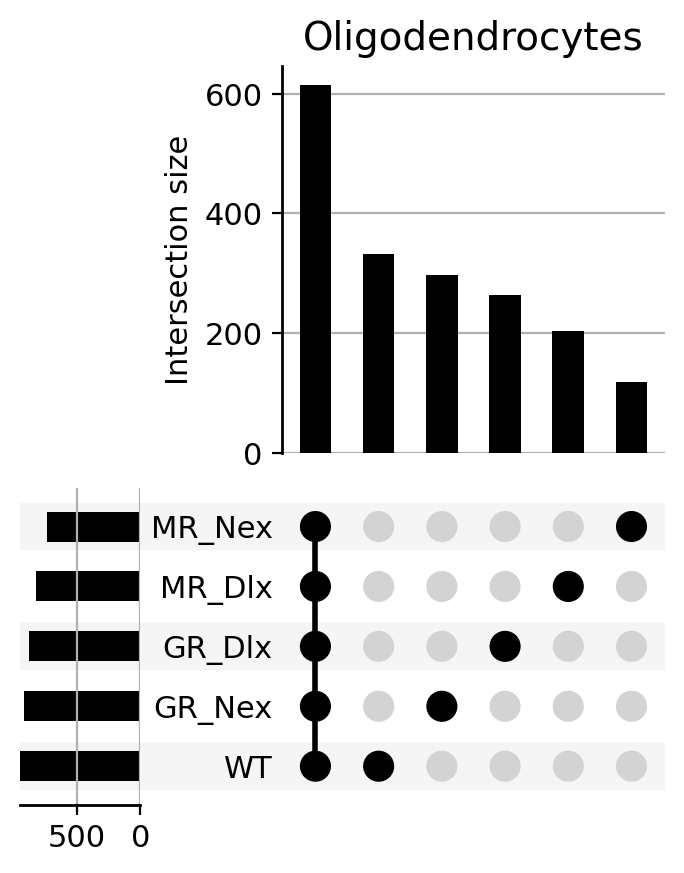

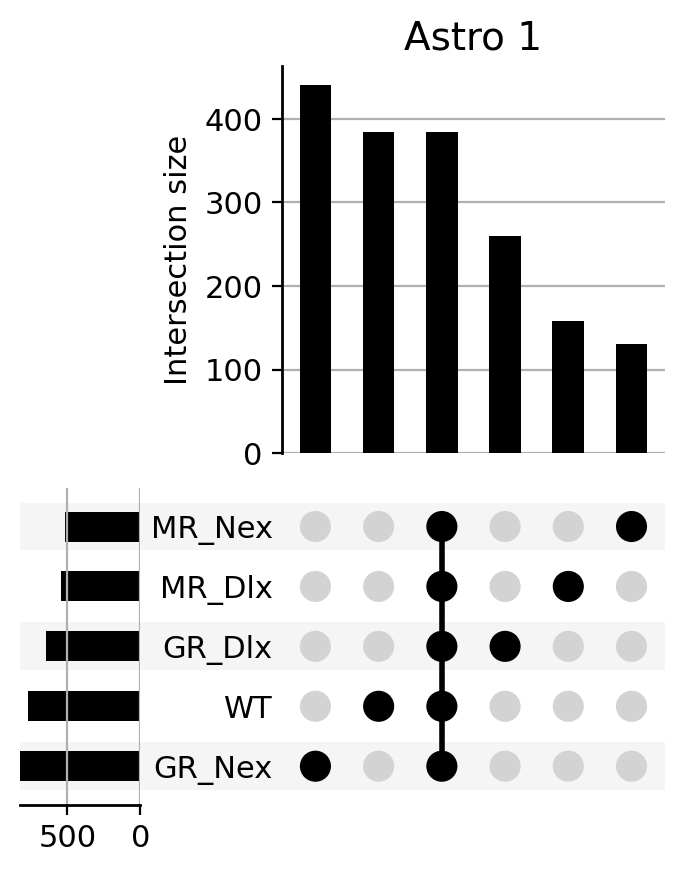

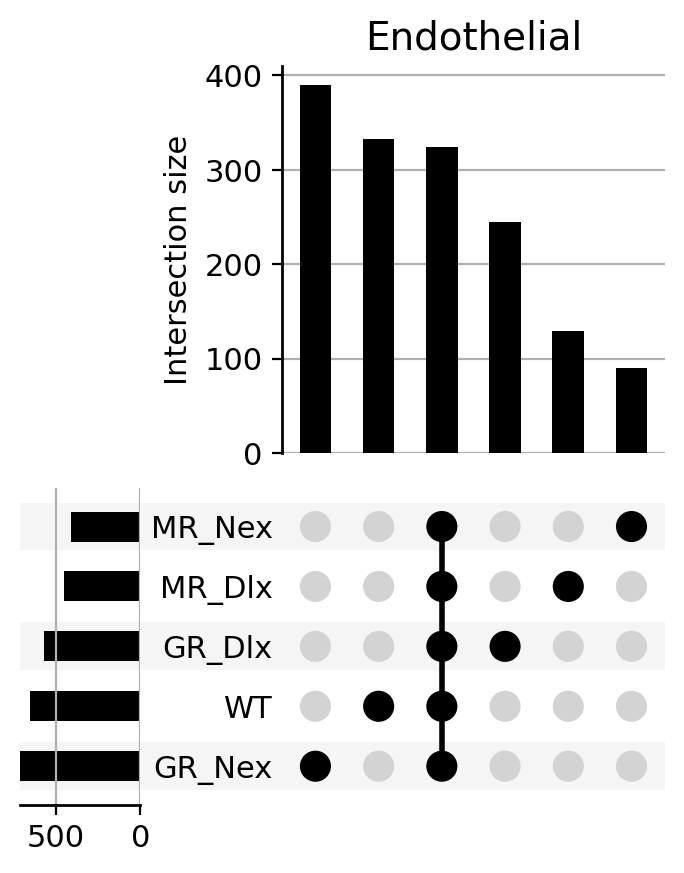

In [49]:
import upsetplot
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Helvetica']
gene_sets = {}
tmp_df = de_genes_sign_mean[~de_genes_sign_mean['test'].isin(['WT_MR', 'WT_GR'])]
min_sizes = [180, 120, 150, 150]
for i, clust in enumerate(['CA1 Glut 2', 'CA3 Glut 2', 'DG Glut 2', 'Oligodendrocytes', "Astro 1", 'Endothelial']):
    print(clust)
    loop_df = tmp_df[tmp_df['clust']==clust]
    for test in loop_df.test.unique():
        gene_sets[test] = set(loop_df[loop_df.test==test].gene.tolist())
    upset_data_sub = upsetplot.from_contents(gene_sets)
    indices = [(True, False, False, False, False),
           (False, True, False, False, False),
           (False, False, True, False, False), 
           (False, False, False, True, False), 
           (False, False, False, False, True),
           (True, True, True, True, True)
          ]
    df_list = []
    for idx in indices:
        df_list.append(upset_data_sub.loc[idx])
    upset_data_sub = pd.concat(df_list)
    axs = upsetplot.plot(upset_data_sub, sort_by='cardinality')#, min_subset_size=min_sizes[i])
    axs['intersections'].set_title(clust)
    #plt.savefig(base_dir + 'figures/upset_' + clust + '_up.png', dpi=600)

In [13]:
upset_data_sub.index

MultiIndex([( True,  True,  True, False,  True),
            ( True,  True, False,  True,  True),
            ( True,  True,  True,  True, False),
            ( True,  True, False, False, False),
            ( True, False,  True, False, False),
            ( True,  True,  True,  True, False),
            ( True,  True,  True,  True,  True),
            ( True, False,  True,  True,  True),
            ( True,  True,  True,  True,  True),
            ( True, False,  True,  True, False),
            ...
            (False, False, False, False,  True),
            (False, False, False, False,  True),
            (False, False, False, False,  True),
            (False, False, False, False,  True),
            (False, False, False, False,  True),
            (False, False, False, False,  True),
            (False, False, False, False,  True),
            (False, False, False, False,  True),
            (False, False, False, False,  True),
            (False, False, False, False,  True)],
   

In [21]:
indices = [(True, False, False, False, False),
           (False, True, False, False, False),
           (False, False, True, False, False), 
           (False, False, False, True, False), 
           (False, False, False, False, True),
           (True, True, True, True, True)
          ]
df_list = []
for idx in indices:
    df_list.append(upset_data_sub.loc[idx])
pd.concat(df_list)

In [26]:
df_list = []
for idx in indices:
    df_list.append(upset_data_sub.loc[idx])

<ipython-input-26-9cba9da13f50>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_list.append(upset_data_sub.loc[idx])


In [28]:
pd.concat(df_list)

id
WT   MR_Dlx GR_Nex GR_Dlx MR_Nex        
True False  False  False  False   Spock3
                          False   Klhdc2
                          False    Rbm22
                          False   Metap1
                          False      Cpd
...                                  ...
     True   True   True   True    Arpc1b
                          True    Dusp11
                          True      Fn3k
                          True     Plpp2
                          True     Azin1

[1830 rows x 1 columns]